# **1. Introduction**

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sb
import torch
from torchvision import models
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights
from torchvision.utils import make_grid
from torch.autograd import Variable
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support
import shutil
import os
import warnings
warnings.filterwarnings("ignore")

code_dir = "/kaggle/working/code"
model_dir = "/kaggle/working/model"
output_dir = "/kaggle/working/output"

if not os.path.exists(code_dir):
    os.mkdir(code_dir)

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

shutil.copyfile(src="/kaggle/input/modelos/convnext.py",
                dst="/kaggle/working/code/convnext.py")
shutil.copyfile(src="/kaggle/input/modelos/convnext_tiny_1k_224_ema.pth",
                dst="/kaggle/working/model/convnext_tiny_1k_224_ema.pth")
shutil.copyfile(src="/kaggle/input/modelos/vit_b_16-c867db91.pth",
                dst="/kaggle/working/model/vit_b_16-c867db91.pth")

os.chdir("/kaggle/working/code")


from convnext import ConvNeXt

In [ ]:
local_arquivos='/kaggle/input/140k-real-and-fake-faces'
treino = pd.read_csv(local_arquivos + "/train.csv")
teste = pd.read_csv(local_arquivos + "/test.csv")
print(teste.shape)
print(treino.shape)

(20000, 6)
(100000, 6)


In [ ]:
# def ConvNeXt_model():
#     model_conv=ConvNeXt()
#     state_dict = torch.load('/kaggle/working/model/convnext_tiny_1k_224_ema.pth')
#     model_conv.load_state_dict(state_dict["model"])
#     return model_conv

# def ViT_model():
#     model_vit=vit_b_16(pretrained=True)
#     return model_vit

In [ ]:
def ViT_model():
    model_vit=vit_b_16(pretrained=True)
    return model_vit

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
train_acc, teste_acc, train_loss, teste_loss = [], [], [], []
train_precision, teste_precision, train_recall, teste_recall = [], [], [], []
train_f1, teste_f1 = [], []
df = pd.DataFrame(columns=['Modelo','Experimento','Epoch', 'Train ACC', 'Train Loss', 'Train F1', 'Test ACC', 'Test Loss', 'Test F1'])

In [ ]:
# def full_data_transform(model_type, data_fraction, batch_size):
#     if model_type== 'convnext':
#         transform = transforms.Compose([
#             transforms.Resize(256),
#             transforms.CenterCrop(256),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#         ])
#     elif model_type == 'vit':
#         transform = ViT_B_16_Weights.IMAGENET1K_V1.transforms()


#     local_arquivos='/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'
#     full_train_dataset = ImageFolder(local_arquivos + "/train", transform=transform)
#     full_test_dataset = ImageFolder(local_arquivos + "/test", transform=transform)
#     num_train_data = int(len(full_train_dataset) * data_fraction)
#     num_test_data = int(len(full_test_dataset) * data_fraction)
#     train_indices = random.sample(range(len(full_train_dataset)), num_train_data)
#     test_indices = random.sample(range(len(full_test_dataset)), num_test_data)
#     train_dataset = torch.utils.data.Subset(full_train_dataset, train_indices)
#     test_dataset = torch.utils.data.Subset(full_test_dataset, test_indices)
#     train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_dataloader = DataLoader(test_dataset, batch_size=int(batch_size/2), shuffle=False)
#     return train_dataloader, test_dataloader

# def ft_data_transform(model_type, data_fraction, batch_size):
#     if model_type == 'vit':
#         transform = ViT_B_16_Weights.IMAGENET1K_V1.transforms()

#     local_arquivos='/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'
#     full_test_dataset = ImageFolder(local_arquivos + "/test", transform=transform)
#     num_test_data = int(len(full_test_dataset) * data_fraction)
#     test_indices = random.sample(range(len(full_test_dataset)), num_test_data)
#     test_dataset = torch.utils.data.Subset(full_test_dataset, test_indices)
#     test_dataloader = DataLoader(test_dataset, batch_size=int(batch_size/2), shuffle=False)

#     return test_dataloader

In [ ]:
def full_data_transform(model_type, data_fraction, batch_size):
    if model_type == 'vit':
        transform = ViT_B_16_Weights.IMAGENET1K_V1.transforms()

    local_arquivos='/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'
    full_train_dataset = ImageFolder(local_arquivos + "/train", transform=transform)
    full_test_dataset = ImageFolder(local_arquivos + "/test", transform=transform)
    num_train_data = int(len(full_train_dataset) * data_fraction)
    num_test_data = int(len(full_test_dataset) * data_fraction)
    train_indices = random.sample(range(len(full_train_dataset)), num_train_data)
    test_indices = random.sample(range(len(full_test_dataset)), num_test_data)
    train_dataset = torch.utils.data.Subset(full_train_dataset, train_indices)
    test_dataset = torch.utils.data.Subset(full_test_dataset, test_indices)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=int(batch_size/2), shuffle=False)
    return train_dataloader, test_dataloader

def ft_data_transform(model_type, data_fraction, batch_size):
    if model_type == 'vit':
        transform = ViT_B_16_Weights.IMAGENET1K_V1.transforms()

    local_arquivos='/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'
    full_test_dataset = ImageFolder(local_arquivos + "/test", transform=transform)
    num_test_data = int(len(full_test_dataset) * data_fraction)
    test_indices = random.sample(range(len(full_test_dataset)), num_test_data)
    test_dataset = torch.utils.data.Subset(full_test_dataset, test_indices)
    test_dataloader = DataLoader(test_dataset, batch_size=int(batch_size/2), shuffle=False)

    return test_dataloader

In [ ]:
def AutoAugment_transform(model_type, train_indices, batch_size):
    if model_type == 'vit':
        augmentation_transforms = transforms.Compose([
            transforms.Resize(224, interpolation=Image.BILINEAR),
            transforms.CenterCrop(224),
            transforms.AutoAugment(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    local_arquivos='/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'
    augmented_train_dataset = ImageFolder(local_arquivos + "/train", transform=augmentation_transforms)
    augmented_train_dataset = torch.utils.data.Subset(augmented_train_dataset, train_indices)
    augmented_train_dataloader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)

    return augmented_train_dataloader

In [ ]:
def RandAugment_transform(model_type, train_indices, batch_size):
    if model_type == 'vit':
        augmentation_transforms = transforms.Compose([
            transforms.Resize(224, interpolation=Image.BILINEAR),
            transforms.CenterCrop(224),
            transforms.RandAugment(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    local_arquivos='/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'
    augmented_train_dataset = ImageFolder(local_arquivos + "/train", transform=augmentation_transforms)
    augmented_train_dataset = torch.utils.data.Subset(augmented_train_dataset, train_indices)
    augmented_train_dataloader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)

    return augmented_train_dataloader

In [ ]:
def Auto_RandAugment_transform(model_type, train_indices, batch_size):
    if model_type == 'vit':
        augmentation_transforms = transforms.Compose([
            transforms.Resize(224, interpolation=Image.BILINEAR),
            transforms.CenterCrop(224),
            transforms.AutoAugment(),
            transforms.RandAugment(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    local_arquivos='/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'
    augmented_train_dataset = ImageFolder(local_arquivos + "/train", transform=augmentation_transforms)
    augmented_train_dataset = torch.utils.data.Subset(augmented_train_dataset, train_indices)
    augmented_train_dataloader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)

    return augmented_train_dataloader

In [ ]:
def train(model, dataloader, criterion, optimizer, scheduler, device, ft, epoch, exp, model_type):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true,y_pred=[], []

    loop = tqdm(enumerate(dataloader), total=len(dataloader))
    for batch_idx, (images, labels) in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        if ft==False:
            for param in model.parameters():
                param.requires_grad=False

            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.step()

            for param in model.parameters():
                param.requires_grad=True
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item()
        predicted = outputs.argmax(dim = 1)

        y_true.extend(labels.cpu().tolist())
        y_pred.extend(predicted.cpu().tolist())

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        loop.set_description(f"[Epoch {(epoch+1)}]")
        loop.set_postfix(loss=loss.item())

    if scheduler:
        scheduler.step()

    train_loss = running_loss / len(dataloader.dataset)
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro',zero_division=0)

    print(f"Train Loss: {train_loss:.6f} | Train Accuracy: {(accuracy * 100):.2f}% | Train F1-Score: {f1:.6f}")

    model_name= f'model_{model_type}_params_exp_{exp}.pth'
    torch.save(model.state_dict(), os.path.join('/kaggle/working/model', model_name))

    return train_loss, accuracy, f1

In [ ]:
def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)


            running_loss += loss.item()
            predicted = outputs.argmax(dim = 1)

            y_true.extend(labels.cpu().tolist())
            y_pred.extend(predicted.cpu().tolist())

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(list(dataloader.dataset))
    test_accuracy = accuracy = accuracy_score(y_true, y_pred)
    precision, recall, test_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro',zero_division=0)

    print(f"Test Loss: {test_loss:.6f} | Test Accuracy: {(test_accuracy * 100):.2f}% | Test F1-Score: {test_f1:.6f}")
    return test_loss, test_accuracy, test_f1, y_pred, y_true

# Orginal training process

In [ ]:
def train_model(model_type, exp,model, train_dataloader, test_dataloader, criterion, optimizer, scheduler, device, num_epochs, ft, num):
    model=model.to(device)
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    val_y_true = []
    val_y_pred = []

    for epoch in range(num_epochs):
        print('----------------------------------------------------------------------------')
        train_loss, train_accuracy, train_f1 = train(model, train_dataloader, criterion, optimizer, scheduler, device, ft, epoch, exp, model_type)
        test_loss, test_accuracy,test_f1,y_pred,y_true = test(model, test_dataloader, criterion, device)
        val=str(num)+str(epoch+1)
        df.loc[val]=[model_type, exp, epoch+1, train_accuracy, train_loss, train_f1, test_accuracy, test_loss, test_f1]
        df.to_csv('metricas.csv', index = False)
        val_y_true.extend(y_true)
        val_y_pred.extend(y_pred)
        print('\n')
        torch.save(model.state_dict(), '/kaggle/working/output/Vit_model_FYP.pth')

    return train_loss, train_accuracy, train_f1, test_loss, test_accuracy,test_f1,val_y_true,val_y_pred

In [ ]:
def run_fyp_scenario(model_type, data_fraction, num_epochs=10, batch_size=32, learning_rate=0.001):
    num_classes = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_train_data = int((100000) * data_fraction)
    num_test_data = int((20000) * data_fraction)

    train_indices = random.sample(range(100000), num_train_data)
    test_indices = random.sample(range(20000), num_test_data)

    print(num_train_data)
    print(num_test_data)
    print("====================Starting==================================")

    train_dataloader, test_dataloader= full_data_transform(model_type, data_fraction, batch_size)

    if model_type == 'vit':
        model = ViT_model()
        model.heads=nn.Linear(768,2)
        num=10

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    print("Experiment 2 - ViT (With Fine-Tuning)")

    train_loss, train_accuracy, train_f1, test_loss, test_accuracy,test_f1,val_y_true,val_y_pred = train_model(model_type,2, model, train_dataloader, test_dataloader,
                                                                                    criterion, optimizer, scheduler, device, num_epochs, True, num)
    return train_loss, train_accuracy, train_f1, test_loss, test_accuracy,test_f1,val_y_true,val_y_pred

# Orginal training process

In [ ]:
#history = run_fyp_scenario('vit',0.1, num_epochs=10, batch_size=16, learning_rate=0.0001)

In [ ]:
#mean_df = df.groupby(['Modelo', 'Experimento']).mean()
#print(mean_df)

# FYP Testing

In [ ]:
train_loss, train_accuracy, train_f1, test_loss, test_accuracy,test_f1,val_y_true,val_y_pred = run_fyp_scenario('vit',1, num_epochs=10, batch_size=16, learning_rate=0.0001)

100000
20000
====================Starting==================================


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 166MB/s]


Experiment 2 - ViT (With Fine-Tuning)
----------------------------------------------------------------------------


[Epoch 1]: 100%|██████████| 6250/6250 [48:33<00:00,  2.15it/s, loss=0.0106]


Train Loss: 0.012895 | Train Accuracy: 91.29% | Train F1-Score: 0.912876
Test Loss: 0.014529 | Test Accuracy: 95.45% | Test F1-Score: 0.954503


----------------------------------------------------------------------------


[Epoch 2]: 100%|██████████| 6250/6250 [39:58<00:00,  2.61it/s, loss=0.0234]


Train Loss: 0.005764 | Train Accuracy: 96.52% | Train F1-Score: 0.965180
Test Loss: 0.008997 | Test Accuracy: 97.22% | Test F1-Score: 0.972247


----------------------------------------------------------------------------


[Epoch 3]: 100%|██████████| 6250/6250 [40:06<00:00,  2.60it/s, loss=0.000495]


Train Loss: 0.000866 | Train Accuracy: 99.52% | Train F1-Score: 0.995200
Test Loss: 0.003606 | Test Accuracy: 99.06% | Test F1-Score: 0.990550


----------------------------------------------------------------------------


[Epoch 4]: 100%|██████████| 6250/6250 [39:59<00:00,  2.61it/s, loss=3.6e-5]


Train Loss: 0.000203 | Train Accuracy: 99.89% | Train F1-Score: 0.998920
Test Loss: 0.005422 | Test Accuracy: 98.92% | Test F1-Score: 0.989250


----------------------------------------------------------------------------


[Epoch 5]: 100%|██████████| 6250/6250 [40:00<00:00,  2.60it/s, loss=4.81e-6]


Train Loss: 0.000045 | Train Accuracy: 99.98% | Train F1-Score: 0.999760
Test Loss: 0.005097 | Test Accuracy: 99.08% | Test F1-Score: 0.990800


----------------------------------------------------------------------------


[Epoch 6]: 100%|██████████| 6250/6250 [39:57<00:00,  2.61it/s, loss=1.81e-6]


Train Loss: 0.000002 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.006181 | Test Accuracy: 99.11% | Test F1-Score: 0.991050


----------------------------------------------------------------------------


[Epoch 7]: 100%|██████████| 6250/6250 [39:51<00:00,  2.61it/s, loss=2.19e-6]


Train Loss: 0.000000 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.006402 | Test Accuracy: 99.12% | Test F1-Score: 0.991200


----------------------------------------------------------------------------


[Epoch 8]: 100%|██████████| 6250/6250 [39:49<00:00,  2.62it/s, loss=1.56e-6]


Train Loss: 0.000000 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.006729 | Test Accuracy: 99.12% | Test F1-Score: 0.991200


----------------------------------------------------------------------------


[Epoch 9]: 100%|██████████| 6250/6250 [39:43<00:00,  2.62it/s, loss=1.51e-6]


Train Loss: 0.000000 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.006767 | Test Accuracy: 99.12% | Test F1-Score: 0.991200


----------------------------------------------------------------------------


[Epoch 10]: 100%|██████████| 6250/6250 [40:04<00:00,  2.60it/s, loss=1.25e-6]


Train Loss: 0.000000 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.006812 | Test Accuracy: 99.13% | Test F1-Score: 0.991300




In [ ]:
values = [train_accuracy ,test_accuracy , train_loss,test_loss, train_f1,test_f1]
values_percentage = [str(round(value * 100, 2)) + '%' for value in values]
df_fyp = pd.DataFrame({
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Train Loss', 'Test Loss', 'Train F1', 'Test F1'],
    'Value': values_percentage
})

In [ ]:
df_fyp

Metric   Value
0  Train Accuracy  100.0%
1   Test Accuracy  99.13%
2      Train Loss    0.0%
3       Test Loss   0.68%
4        Train F1  100.0%
5         Test F1  99.13%

# Plotting Code

In [ ]:
def plot_acc_graphs(df):
    fig, ax = plt.subplots(figsize=(6, 4))

    # Plot epoch x train F1
    for experiment_number in df['Experimento'].unique():
        experiment_df = df[df['Experimento'] == experiment_number]
        ax.plot(experiment_df['Epoch'], experiment_df['Train ACC'], marker='o', label=f'Train Set')

    # Plot epoch x train loss
    for experiment_number in df['Experimento'].unique():
        experiment_df = df[df['Experimento'] == experiment_number]
        ax.plot(experiment_df['Epoch'], experiment_df['Test ACC'], marker='o', linestyle='--', label=f'Val Set')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Value')
    ax.set_title('Model Accuracy')
    ax.legend()
    ax.set_ylim(bottom=0.75)
    plt.show()

def plot_loss_graphs(df):
    fig, ax = plt.subplots(figsize=(6, 4))

    # Plot epoch x train F1
    for experiment_number in df['Experimento'].unique():
        experiment_df = df[df['Experimento'] == experiment_number]
        ax.plot(experiment_df['Epoch'], experiment_df['Train Loss'], marker='o', label=f'Train Set')

    # Plot epoch x train loss
    for experiment_number in df['Experimento'].unique():
        experiment_df = df[df['Experimento'] == experiment_number]
        ax.plot(experiment_df['Epoch'], experiment_df['Test Loss'], marker='o', linestyle='--', label=f'Val Set')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Value')
    ax.set_title('Model Loss')
    ax.legend()
    ax.set_ylim(top=0.50)
    plt.show()

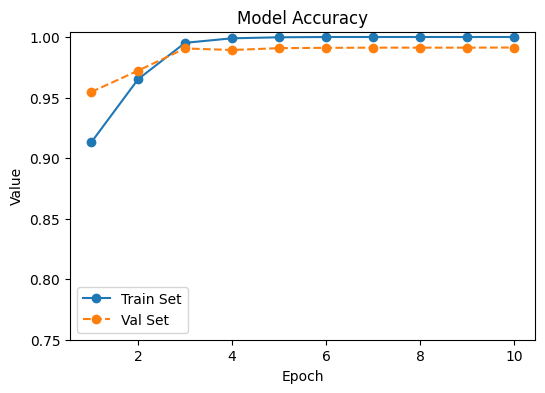

In [ ]:
plot_acc_graphs(df)

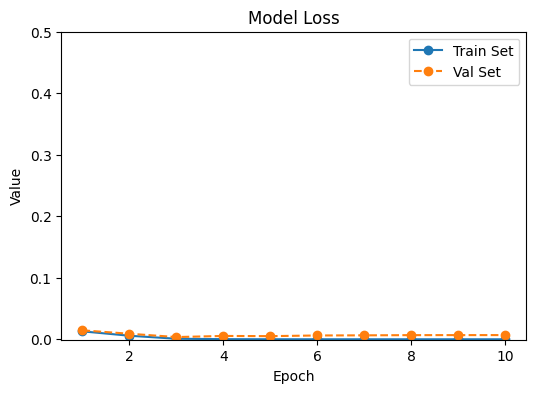

In [ ]:
plot_loss_graphs(df)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, epoch):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'ViT Model Confusion Matrix (Epoch {epoch + 1})')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = conf_matrix.max() / 2.0
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, conf_matrix[i, j], horizontalalignment="center", color="white" if conf_matrix[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.tight_layout()
    plt.show()

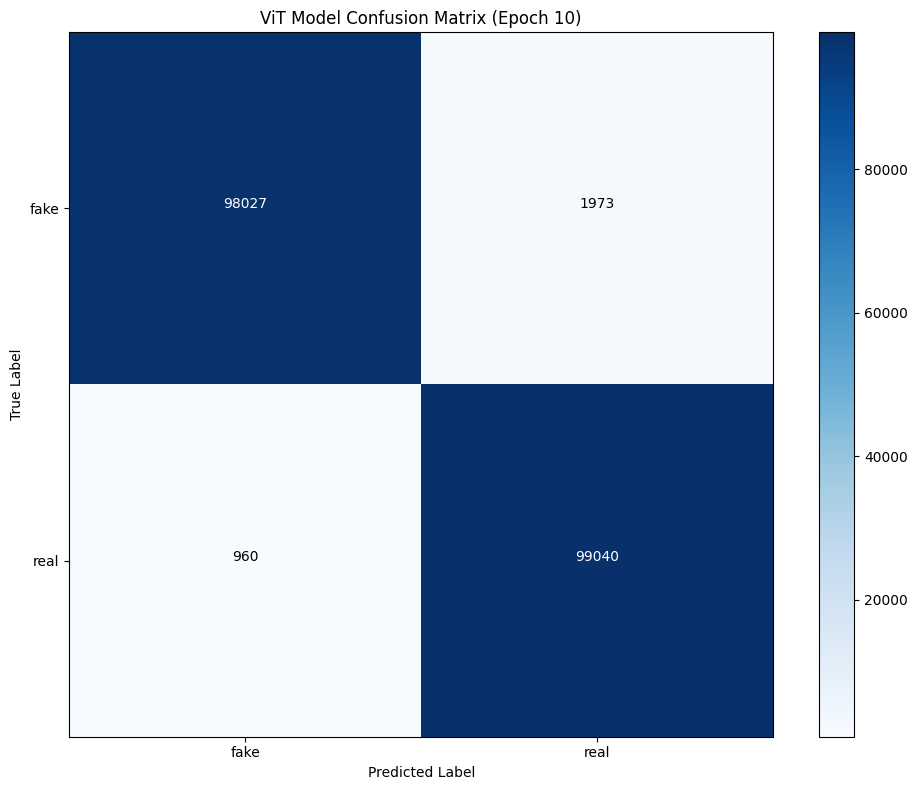

In [ ]:
class_names = ['fake', 'real']
num_epochs = 10
#unique_labels = np.unique(val_y_true)
#class_names = [str(label) for label in unique_labels]
plot_confusion_matrix(val_y_true, val_y_pred, class_names, num_epochs - 1)

In [ ]:
from sklearn.metrics import classification_report
# Print training metrics
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")
print(f"Training F1 Score: {train_f1}")

# Print testing metrics
print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_accuracy}")
print(f"Testing F1 Score: {test_f1}")

# Generate classification report
report = classification_report(val_y_true, val_y_pred, target_names=['fake', 'real'])

print("")
print("Classification Report:")
print(report)

Training Loss: 1.272494835654925e-07
Training Accuracy: 1.0
Training F1 Score: 1.0
Testing Loss: 0.006811516616404322
Testing Accuracy: 0.9913
Testing F1 Score: 0.9912999829479665

Classification Report:
              precision    recall  f1-score   support

        fake       0.99      0.98      0.99    100000
        real       0.98      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000



In [ ]:
df.to_csv('Metrics.csv', index = False)

# Load the model

In [ ]:
model = ViT_model()
model.heads=nn.Linear(768,2)
model.load_state_dict(torch.load('/kaggle/working/output/Vit_model_FYP.pth'))
model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
num_param = sum(p.numel() for p in model.parameters())
print(num_param)

85800194


In [ ]:
test_variable = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/04IISQZW0V.jpg'
test_variable_ck = os.path.basename(test_variable)
print(test_variable_ck)

04IISQZW0V.jpg


In [ ]:
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
            transforms.Resize(224, interpolation=Image.BILINEAR),
            transforms.CenterCrop(224),
            #transforms.AutoAugment(),
            #transforms.RandAugment(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = Image.open(test_variable)
image = transform(image)

In [ ]:
predict_df = pd.read_csv('/kaggle/input/140k-real-and-fake-faces/test.csv')
#predict_df

In [ ]:
predict_id = 'test/fake/'+test_variable_ck
Actual_label = predict_df[predict_df['path'] == predict_id]
#print(Actual_label)
label_str_value = Actual_label['label_str'].values[0]
Actual_label = label_str_value

In [ ]:
import os
def get_data():
    return pd.read_csv('/kaggle/input/140k-real-and-fake-faces/test.csv')

In [ ]:
predict_df=get_data()
predict_df.head()

Unnamed: 0                                      original_path     id  \
0           0  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  18233   
1           1  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  54317   
2           2  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  40155   
3           3  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  12875   
4           4  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  52543   

   label label_str                 path  
0      1      real  test/real/18233.jpg  
1      1      real  test/real/54317.jpg  
2      1      real  test/real/40155.jpg  
3      1      real  test/real/12875.jpg  
4      1      real  test/real/52543.jpg

In [ ]:
image_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/04IISQZW0V.jpg'
image = Image.open(image_path)
image = transform(image)
image = image.unsqueeze(0)

# Compute attention map
# Since the model does not have a get_attention_map method, we need to modify this part
# Here, we assume that the model has a forward method that returns the attention map
with torch.no_grad():
    attention_map = model.forward(image)
    attention_map = attention_map.cpu()

# Print the shape of the attention map
print(f"The shape of the attention map is: {attention_map.shape}")

The shape of the attention map is: torch.Size([1, 2])


Start predict
--------------------------------------------------------------------------
train/fake/UWNL1REVF2.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/fake/UWNL1REVF2.jpg
Check 1: Probabilities: tensor([[6.2520e-06, 9.9999e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Check 2: torch.return_types.max(
values=tensor([6.3807], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1], device='cuda:0'))
Check 3: real
Fake probability: 0.0 %
Real probability: 100.0 %
--------------------------------------------------------------------------
End predict

Start predict
--------------------------------------------------------------------------
train/fake/30Y94ZJIBZ.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/fake/30Y94ZJIBZ.jpg
Check 1: Probabilities: tensor([[1.0000e+00, 1.1159e-06]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Check 2: torch.return_types.max(
values=tensor([6.8319], device='cuda:0', grad_fn=<MaxBackw

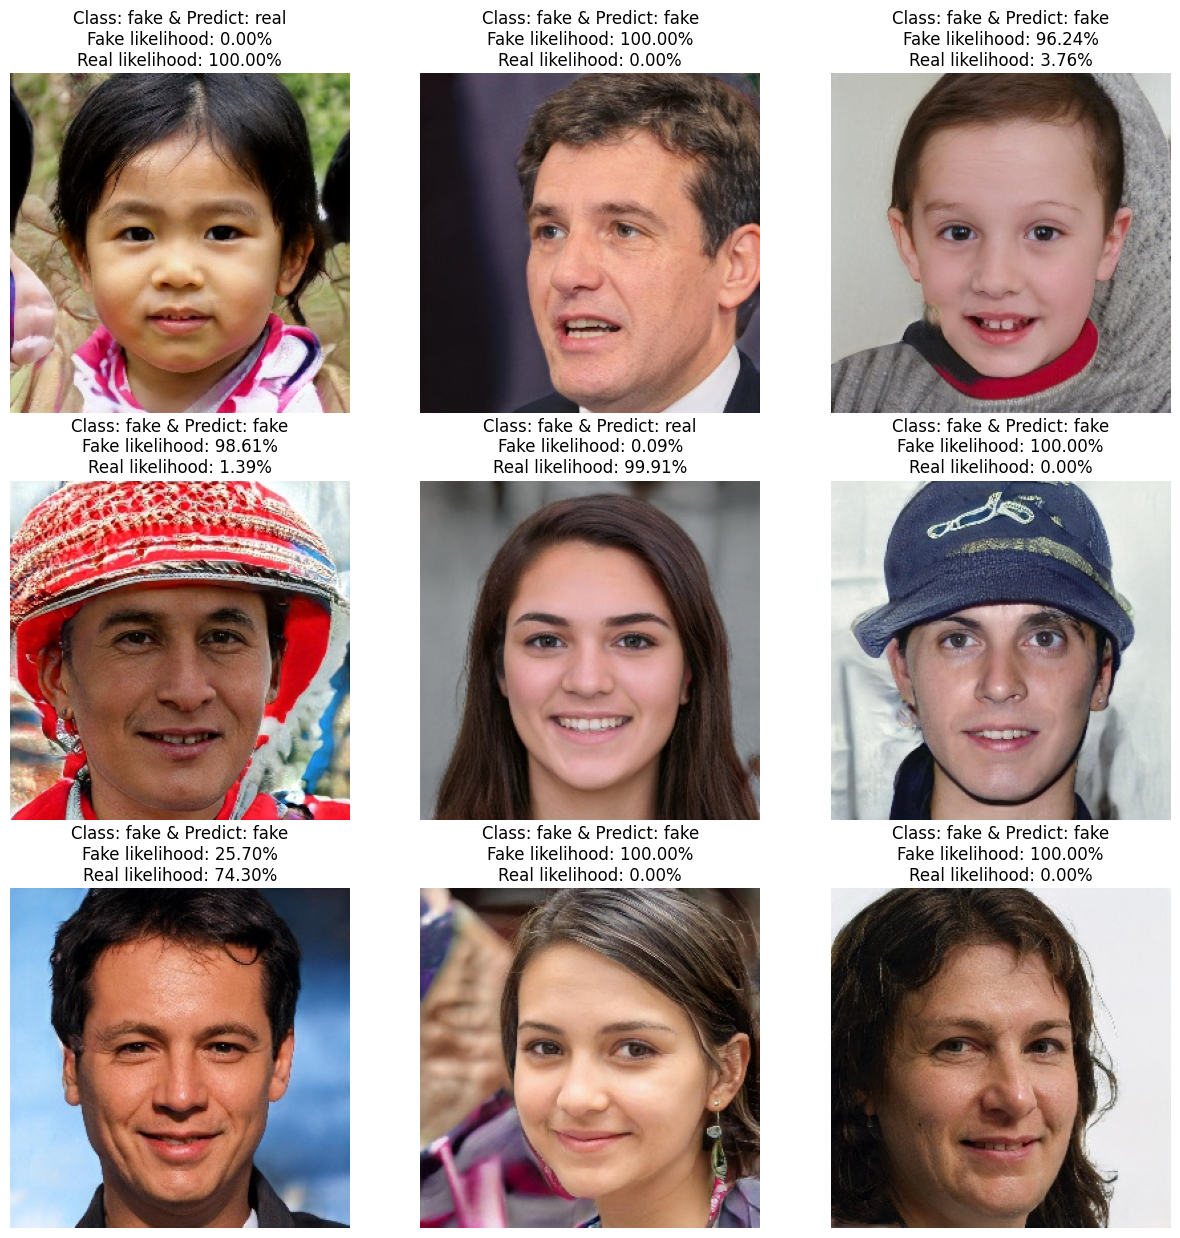

In [ ]:
import cv2
import torch.nn.functional as F

# Load the dataframe
predict_df = pd.read_csv('/kaggle/input/140k-real-and-fake-faces/train.csv')

# Define the class names
class_names = ['fake', 'real']

model.to('cuda')
correct_predictions = 0

# Start the prediction loop
random_number = random.randint(1, len(predict_df) - 10)
plt.figure(figsize=(15,15))

for cur, i in enumerate(predict_df.index[random_number:random_number+9]):
    plt.subplot(3, 3, cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/' + predict_df.loc[i, 'path']
    print('Start predict')
    print('--------------------------------------------------------------------------')
    print(predict_df.loc[i, 'path'])
    print(image_path)
    image_bgr = cv2.imread(image_path)
    if image_bgr is not None:
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)

        # Open the image and apply the transform
        image = Image.open(image_path)
        image = transform(image)
        image = image.unsqueeze(0).to('cuda')

        num_predictions = 10
        probabilities_list = []
        for _ in range(num_predictions):
            output = model(image)
            probabilities = F.softmax(output, dim=1)
            probabilities_list.append(probabilities.tolist()[0])

        # Average the probabilities
        avg_probabilities = np.mean(probabilities_list, axis=0)
        print('Check 1: Probabilities: ' + str(probabilities))
        fake_probability = probabilities_list[0][0]
        real_probability = probabilities_list[0][1]
        fake_probability_percentage = fake_probability * 100
        real_probability_percentage = real_probability * 100

        predicted = torch.max(output, 1)
        print('Check 2: '+ str(predicted))

        predicted_label = class_names[predicted.indices.item()]
        if fake_probability_percentage >= 1:
            predicted_label = 'fake'
        print('Check 3: '+ str(predicted_label))

        if(predict_df.loc[i,'label']==1):
            classt='real'
        else:
            classt='fake'

        print('Fake probability: '+ str(round(fake_probability_percentage,2)) + ' %')
        print('Real probability: '+ str(round(real_probability_percentage,2)) + ' %')
        print('--------------------------------------------------------------------------')
        print('End predict')
        print("")

        if predicted_label == classt:
            correct_predictions += 1

        plt.title(f"Class: {classt} & Predict: {predicted_label}\nFake likelihood: {fake_probability_percentage:.2f}%\nReal likelihood: {real_probability_percentage:.2f}%")
    else:
        print(f"Image not found at: {image_path}")
    plt.axis("off")

print(f"Number of correct predictions: {correct_predictions}"+'/'+'9' + ' = ' + str(round(correct_predictions/9*100,2)) + '%')
plt.show()

Start predict
--------------------------------------------------------------------------
train/real/59313.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real/59313.jpg
Check 1: Probabilities: tensor([[1.5885e-06, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Check 2: torch.return_types.max(
values=tensor([6.9352], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1], device='cuda:0'))
Check 3: real
Fake probability: 0.0 %
Real probability: 100.0 %
--------------------------------------------------------------------------
End predict

Start predict
--------------------------------------------------------------------------
train/real/10434.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real/10434.jpg
Check 1: Probabilities: tensor([[1.3219e-06, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Check 2: torch.return_types.max(
values=tensor([6.9822], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tens

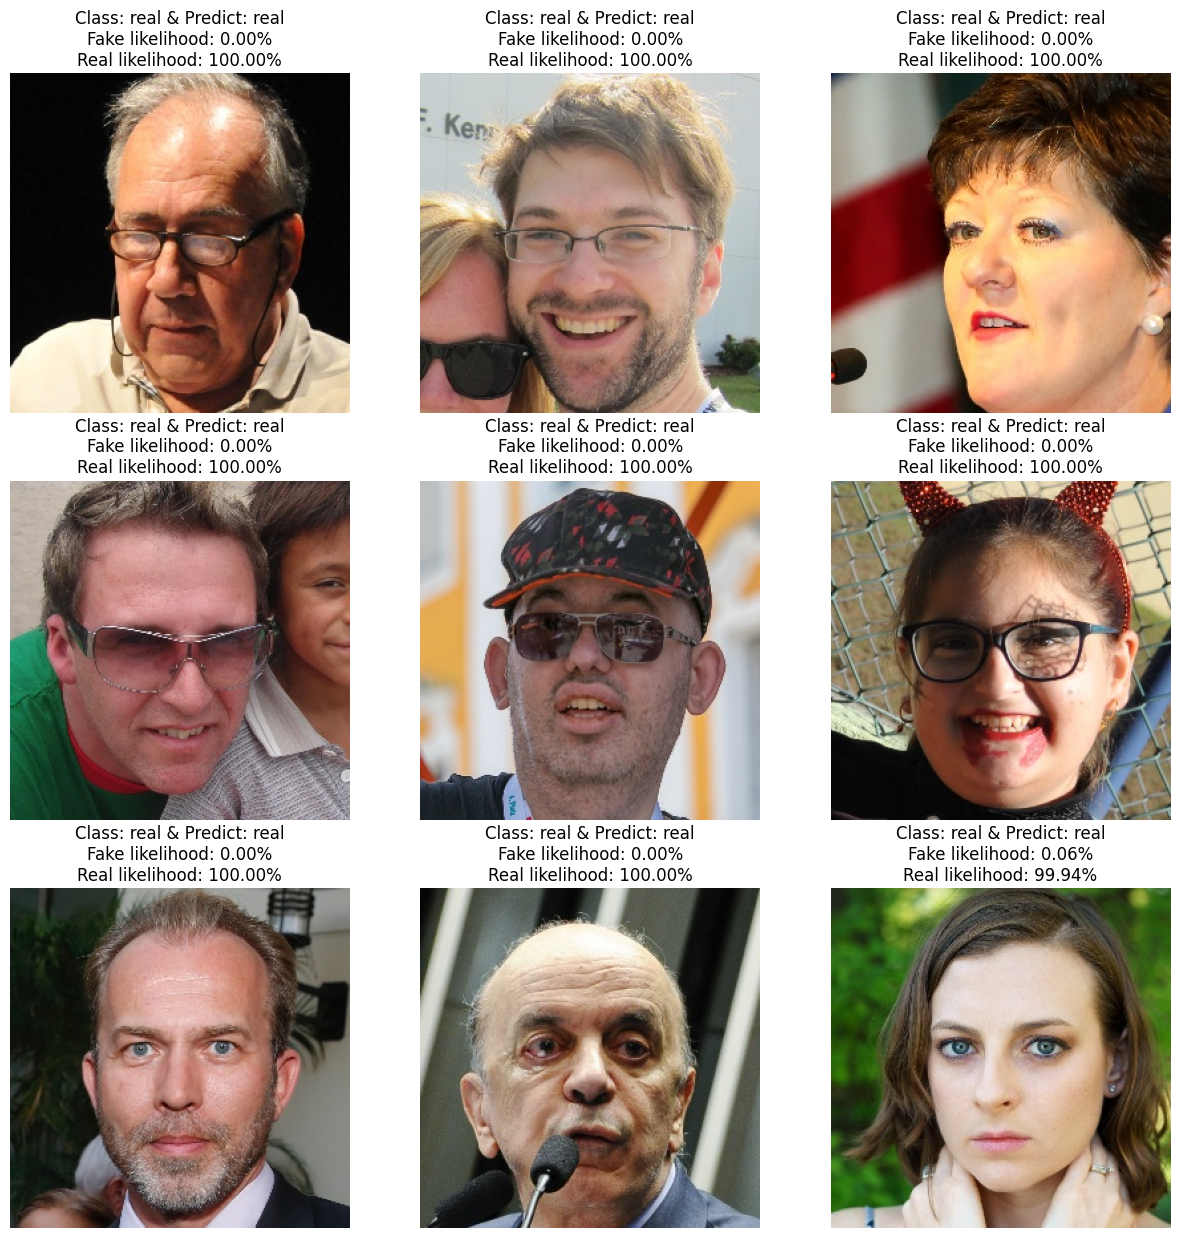

In [ ]:
import cv2
import torch.nn.functional as F

# Load the dataframe
predict_df = pd.read_csv('/kaggle/input/140k-real-and-fake-faces/train.csv')

# Define the class names
class_names = ['fake', 'real']

model.to('cuda')
correct_predictions = 0

# Start the prediction loop
random_number = random.randint(1, len(predict_df) - 10)
plt.figure(figsize=(15,15))

for cur, i in enumerate(predict_df.index[random_number:random_number+9]):
    plt.subplot(3, 3, cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/' + predict_df.loc[i, 'path']
    print('Start predict')
    print('--------------------------------------------------------------------------')
    print(predict_df.loc[i, 'path'])
    print(image_path)
    image_bgr = cv2.imread(image_path)
    if image_bgr is not None:
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)

        # Open the image and apply the transform
        image = Image.open(image_path)
        image = transform(image)
        image = image.unsqueeze(0).to('cuda')

        num_predictions = 1
        probabilities_list = []
        for _ in range(num_predictions):
            output = model(image)
            probabilities = F.softmax(output, dim=1)
            probabilities_list.append(probabilities.tolist()[0])

        # Average the probabilities
        avg_probabilities = np.mean(probabilities_list, axis=0)
        print('Check 1: Probabilities: ' + str(probabilities))
        fake_probability = probabilities_list[0][0]
        real_probability = probabilities_list[0][1]
        fake_probability_percentage = fake_probability * 100
        real_probability_percentage = real_probability * 100

        predicted = torch.max(output, 1)
        print('Check 2: '+ str(predicted))

        predicted_label = class_names[predicted.indices.item()]
        if fake_probability_percentage >= 50:
            predicted_label = 'fake'
        print('Check 3: '+ str(predicted_label))

        if(predict_df.loc[i,'label']==1):
            classt='real'
        else:
            classt='fake'

        print('Fake probability: '+ str(round(fake_probability_percentage,2)) + ' %')
        print('Real probability: '+ str(round(real_probability_percentage,2)) + ' %')
        print('--------------------------------------------------------------------------')
        print('End predict')
        print("")

        if predicted_label == classt:
            correct_predictions += 1

        plt.title(f"Class: {classt} & Predict: {predicted_label}\nFake likelihood: {fake_probability_percentage:.2f}%\nReal likelihood: {real_probability_percentage:.2f}%")
    else:
        print(f"Image not found at: {image_path}")
    plt.axis("off")

print(f"Number of correct predictions: {correct_predictions}"+'/'+'9' + ' = ' + str(round(correct_predictions/9*100,2)) + '%')
plt.show()

# Predict unseen data

In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

# Load the dataset
predict_df = pd.read_csv('/kaggle/input/140k-real-and-fake-faces/valid.csv')

# Define the class names
class_names = ['fake', 'real']

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Preprocess images
preprocessed_images = []
for i in predict_df.index:
    image_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/' + predict_df.loc[i, 'path']
    image = Image.open(image_path)
    # Assuming you have a 'transform' function for preprocessing
    image = transform(image)
    preprocessed_images.append(image)

# Move the model to GPU (if available)
model.to('cuda')

# Start the prediction loop
with torch.no_grad():
    start_time = time.time()
    for i, image in enumerate(preprocessed_images):
        image = image.unsqueeze(0).to('cuda')
        output = model(image)
        predicted = torch.max(output, 1)
        predicted_label = class_names[predicted.indices.item()]

        if predict_df.loc[i, 'label'] == 1:
            true_label = 'real'
        else:
            true_label = 'fake'

        # Append the true label and predicted label to their respective lists
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)

        # Print progress every 100 images
        if i % 1000 == 0 and i > 0:
            elapsed_time = time.time() - start_time
            images_per_second = i / elapsed_time
            remaining_images = len(predict_df) - i
            estimated_time_remaining = remaining_images / images_per_second
            print(f"Processed {i} images. Estimated time remaining: {estimated_time_remaining:.2f} seconds.")

# Convert the lists of true labels and predicted labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Calculate the classification report
cr = classification_report(true_labels, predicted_labels, target_names=class_names)
print("")
# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(cr)

Processed 1000 images. Estimated time remaining: 193.60 seconds.
Processed 2000 images. Estimated time remaining: 183.26 seconds.
Processed 3000 images. Estimated time remaining: 173.36 seconds.
Processed 4000 images. Estimated time remaining: 163.02 seconds.
Processed 5000 images. Estimated time remaining: 152.81 seconds.
Processed 6000 images. Estimated time remaining: 142.52 seconds.
Processed 7000 images. Estimated time remaining: 132.33 seconds.
Processed 8000 images. Estimated time remaining: 122.13 seconds.
Processed 9000 images. Estimated time remaining: 111.92 seconds.
Processed 10000 images. Estimated time remaining: 101.72 seconds.
Processed 11000 images. Estimated time remaining: 91.53 seconds.
Processed 12000 images. Estimated time remaining: 81.35 seconds.
Processed 13000 images. Estimated time remaining: 71.17 seconds.
Processed 14000 images. Estimated time remaining: 60.99 seconds.
Processed 15000 images. Estimated time remaining: 50.81 seconds.
Processed 16000 images. 

# Reset Threshold version

# StyleGAN3 (2021)

/kaggle/input/fyp-2803-test-case/FYP_test_case/StyleGAN3 (2021)/g3_005.png
Check 1: Probabilities: tensor([[1.3254e-06, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Check 2: torch.return_types.max(
values=tensor([6.9557], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1], device='cuda:0'))
Check 3: real
Fake probability: 0.0001325424705100886
Real probability: 99.9998688697815
--------------------------------------------------------------------------
End predict

/kaggle/input/fyp-2803-test-case/FYP_test_case/StyleGAN3 (2021)/g3_002.png
Check 1: Probabilities: tensor([[3.4476e-06, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Check 2: torch.return_types.max(
values=tensor([6.5583], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1], device='cuda:0'))
Check 3: real
Fake probability: 0.0003447611334195244
Real probability: 99.9996542930603
--------------------------------------------------------------------------
End predict

/kaggle/input/

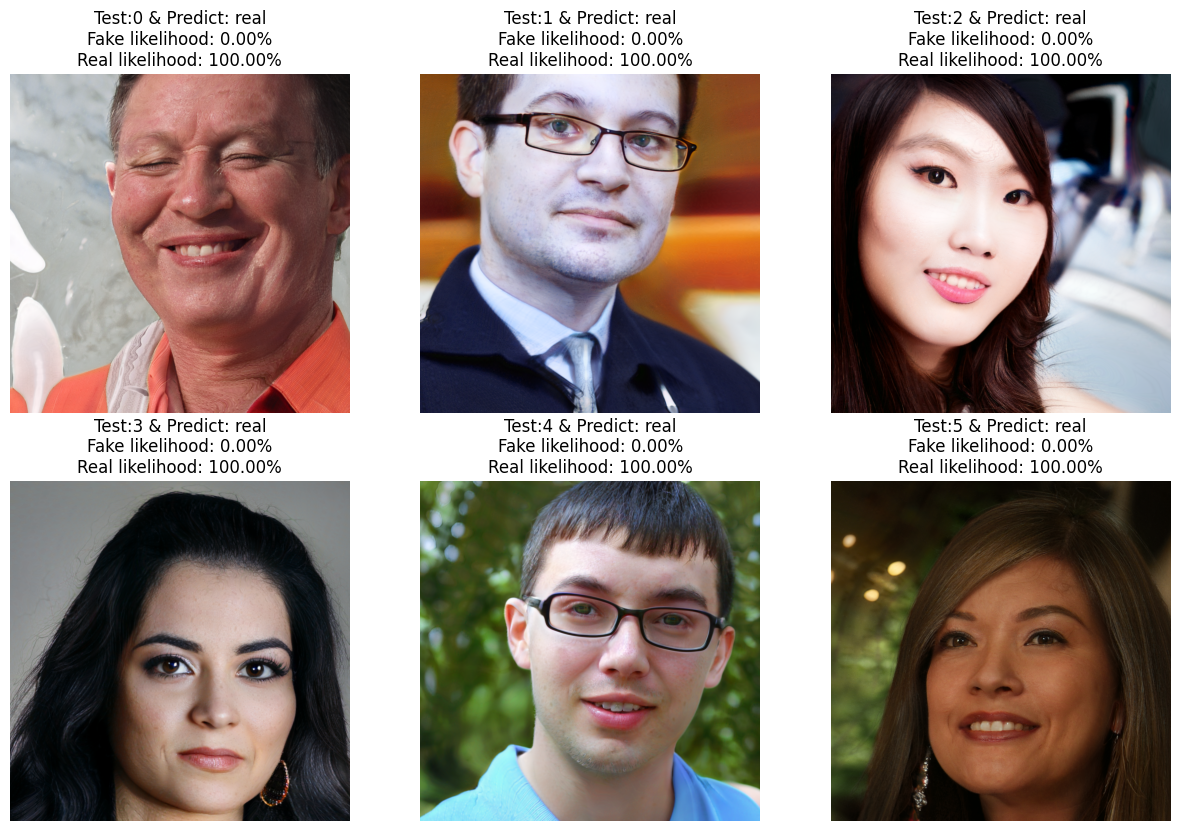

In [ ]:
class_names = ['fake', 'real']

# Get the list of all image paths
image_folder_path = '/kaggle/input/fyp-2803-test-case/FYP_test_case/StyleGAN3 (2021)'
image_paths = [os.path.join(image_folder_path, filename) for filename in os.listdir(image_folder_path)]

# Start the prediction loop
num_images = len(image_paths)
num_images_to_show = min(9, num_images)
plt.figure(figsize=(15,15))
model.to('cuda')

for cur in range(num_images_to_show):
    plt.subplot(3, 3, cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image_path = image_paths[cur]
    print(image_path)
    image_bgr = cv2.imread(image_path)
    if image_bgr is not None:
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)

        # Open the image and apply the transform
        image = Image.open(image_path)
        image = transform(image)
        image = image.unsqueeze(0).to('cuda')

        num_predictions = 1
        probabilities_list = []
        for _ in range(num_predictions):
            output = model(image)
            probabilities = F.softmax(output, dim=1)
            #probabilities = torch.max(output, 1)
            probabilities_list.append(probabilities.tolist()[0])

        # Average the probabilities
        avg_probabilities = np.mean(probabilities_list, axis=0)
        print('Check 1: Probabilities: ' + str(probabilities))
        fake_probability = probabilities_list[0][0]
        real_probability = probabilities_list[0][1]
        fake_probability_percentage = fake_probability * 100
        real_probability_percentage = real_probability * 100

        predicted = torch.max(output, 1)
        print('Check 2: '+ str(predicted))

        predicted_label = class_names[predicted.indices.item()]
        if fake_probability_percentage >= 50:
            predicted_label = 'fake'
        else:
            predicted_label = 'real'
        print('Check 3: '+ str(predicted_label))
        print('Fake probability: '+ str(fake_probability_percentage))
        print('Real probability: '+ str(real_probability_percentage))
        print('--------------------------------------------------------------------------')
        print('End predict')
        print("")

        plt.title(f"Test:{cur} & Predict: {predicted_label}\nFake likelihood: {fake_probability_percentage:.2f}%\nReal likelihood: {real_probability_percentage:.2f}%")
    else:
        print(f"Image not found at: {image_path}")
    plt.axis("off")
plt.show()

# StyleGAN2 (2019)

/kaggle/input/fyp-2803-test-case/FYP_test_case/StyleGAN2 (2019)/g2_003.jpg
Check 1: Probabilities: tensor([[1.3138e-06, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Check 2: torch.return_types.max(
values=tensor([6.9222], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1], device='cuda:0'))
Check 3: real
Fake probability: 0.00013138239864929346
Real probability: 99.9998688697815
--------------------------------------------------------------------------
End predict

/kaggle/input/fyp-2803-test-case/FYP_test_case/StyleGAN2 (2019)/g2_004.jpg
Check 1: Probabilities: tensor([[2.3268e-06, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Check 2: torch.return_types.max(
values=tensor([6.6952], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1], device='cuda:0'))
Check 3: real
Fake probability: 0.0002326791900486569
Real probability: 99.9997615814209
--------------------------------------------------------------------------
End predict

/kaggle/input

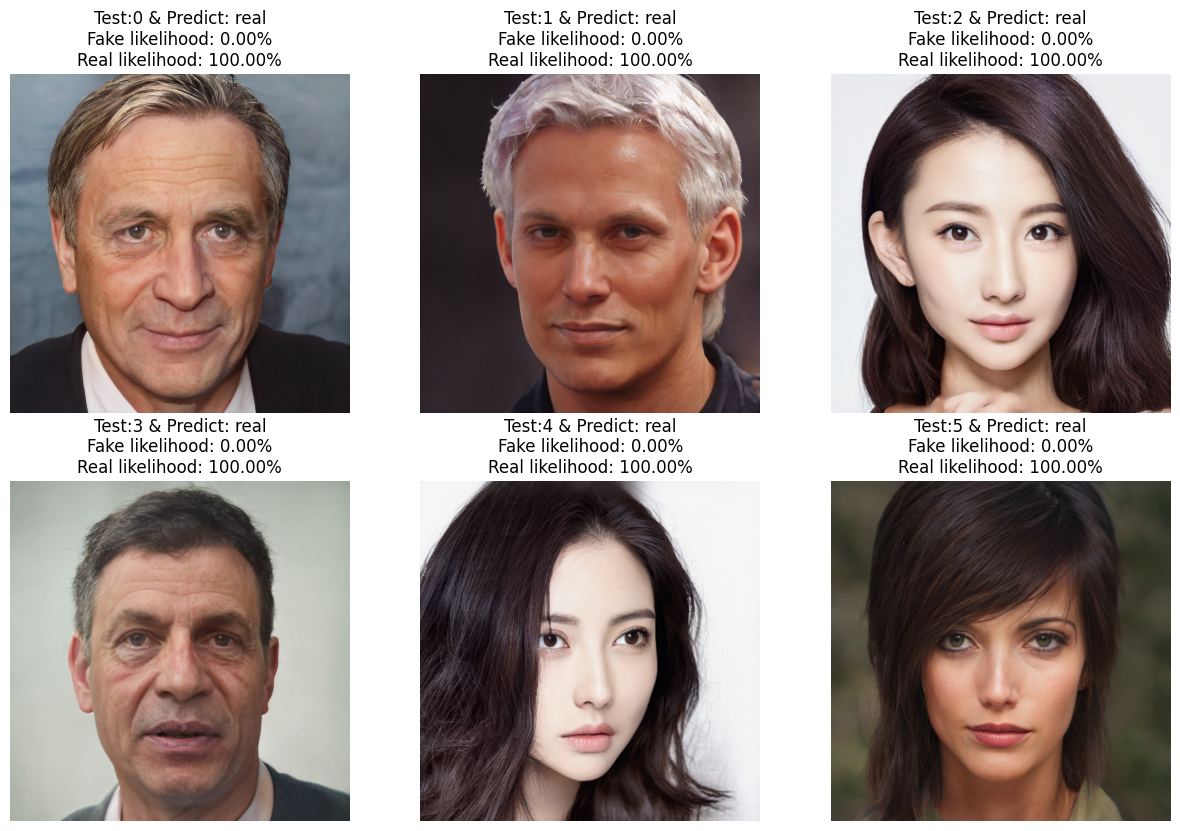

In [ ]:
class_names = ['fake', 'real']

# Get the list of all image paths
image_folder_path = '/kaggle/input/fyp-2803-test-case/FYP_test_case/StyleGAN2 (2019)'
image_paths = [os.path.join(image_folder_path, filename) for filename in os.listdir(image_folder_path)]

# Start the prediction loop
num_images = len(image_paths)
num_images_to_show = min(9, num_images)
plt.figure(figsize=(15,15))
model.to('cuda')

for cur in range(num_images_to_show):
    plt.subplot(3, 3, cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image_path = image_paths[cur]
    print(image_path)
    image_bgr = cv2.imread(image_path)
    if image_bgr is not None:
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)

        # Open the image and apply the transform
        image = Image.open(image_path)
        image = transform(image)
        image = image.unsqueeze(0).to('cuda')

        num_predictions = 1
        probabilities_list = []
        for _ in range(num_predictions):
            output = model(image)
            probabilities = F.softmax(output, dim=1)
            probabilities_list.append(probabilities.tolist()[0])

        # Average the probabilities
        avg_probabilities = np.mean(probabilities_list, axis=0)
        print('Check 1: Probabilities: ' + str(probabilities))
        fake_probability = probabilities_list[0][0]
        real_probability = probabilities_list[0][1]
        fake_probability_percentage = fake_probability * 100
        real_probability_percentage = real_probability * 100

        predicted = torch.max(output, 1)
        print('Check 2: '+ str(predicted))

        predicted_label = class_names[predicted.indices.item()]
        if fake_probability_percentage >= 50:
            predicted_label = 'fake'
        else:
            predicted_label = 'real'
        print('Check 3: '+ str(predicted_label))
        print('Fake probability: '+ str(fake_probability_percentage))
        print('Real probability: '+ str(real_probability_percentage))
        print('--------------------------------------------------------------------------')
        print('End predict')
        print("")

        plt.title(f"Test:{cur} & Predict: {predicted_label}\nFake likelihood: {fake_probability_percentage:.2f}%\nReal likelihood: {real_probability_percentage:.2f}%")
    else:
        print(f"Image not found at: {image_path}")
    plt.axis("off")
plt.show()

# Real World

/kaggle/input/fyp-2803-test-case/FYP_test_case/RealFaces/rl_03.png
Check 1: Probabilities: tensor([[1.2236e-06, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Check 2: torch.return_types.max(
values=tensor([7.0821], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1], device='cuda:0'))
Check 3: real
Fake probability: 0.00012235611848154804
Real probability: 99.99988079071045
--------------------------------------------------------------------------
End predict

/kaggle/input/fyp-2803-test-case/FYP_test_case/RealFaces/rl_04.jpg
Check 1: Probabilities: tensor([[1.7276e-06, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Check 2: torch.return_types.max(
values=tensor([6.9053], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1], device='cuda:0'))
Check 3: real
Fake probability: 0.00017275798427363043
Real probability: 99.99983310699463
--------------------------------------------------------------------------
End predict

/kaggle/input/fyp-2803-tes

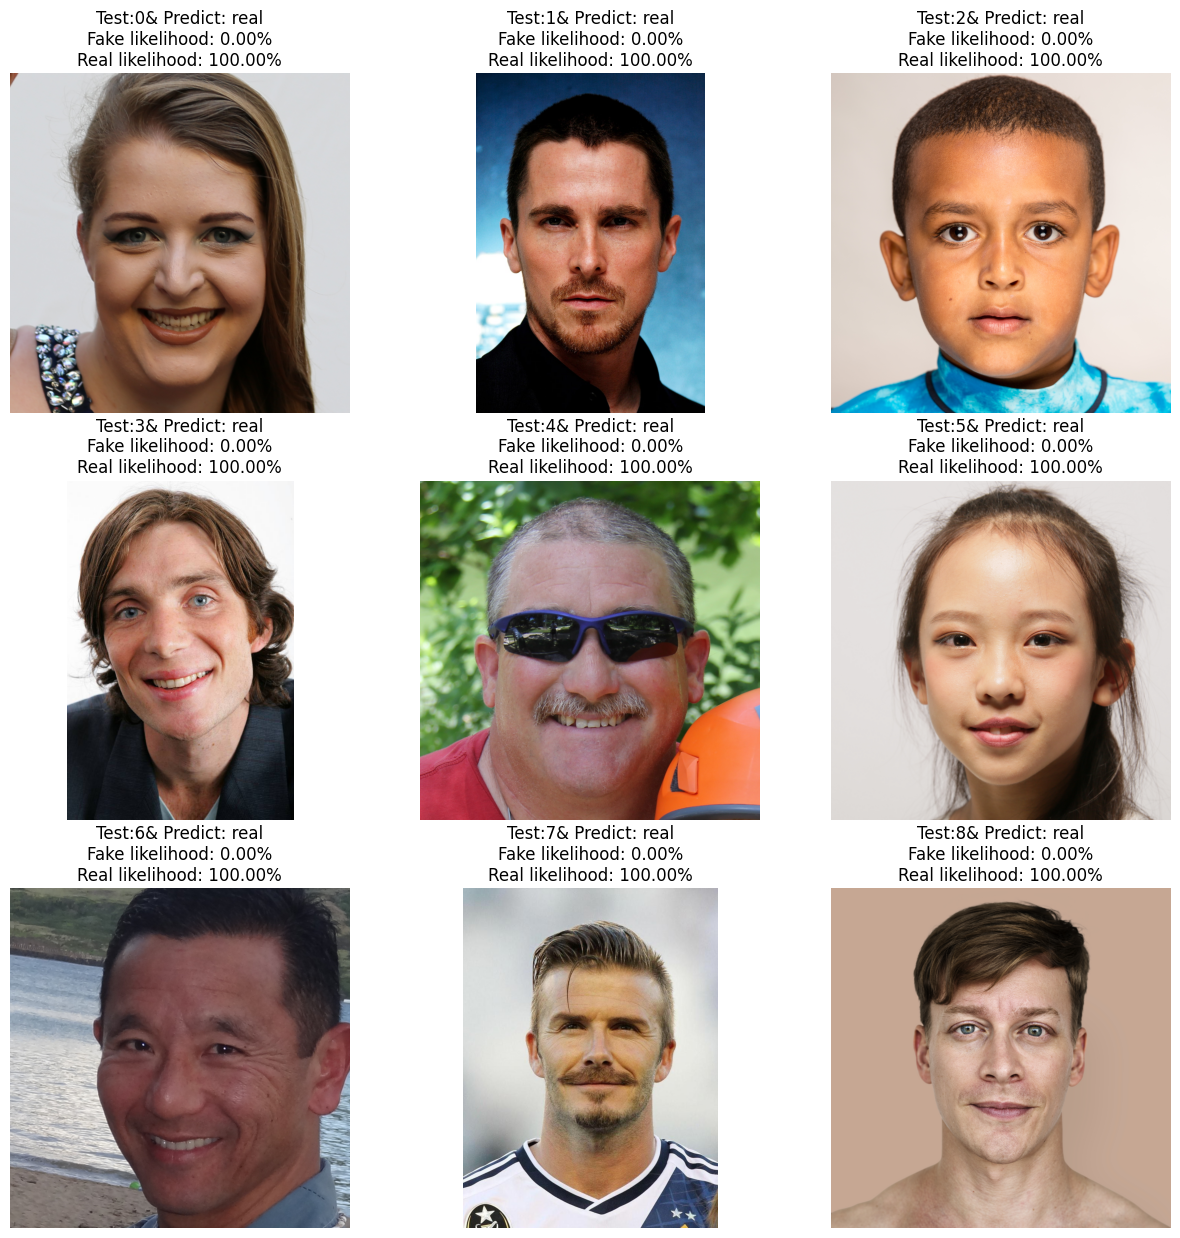

In [ ]:
class_names = ['fake', 'real']

# Get the list of all image paths
image_folder_path = '/kaggle/input/fyp-2803-test-case/FYP_test_case/RealFaces'
image_paths = [os.path.join(image_folder_path, filename) for filename in os.listdir(image_folder_path)]

# Start the prediction loop
num_images = len(image_paths)
num_images_to_show = min(9, num_images)
plt.figure(figsize=(15,15))
model.to('cuda')

for cur in range(num_images_to_show):
    plt.subplot(3, 3, cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image_path = image_paths[cur]
    print(image_path)
    image_bgr = cv2.imread(image_path)
    if image_bgr is not None:
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)

        # Open the image and apply the transform
        image = Image.open(image_path)
        image = transform(image)
        image = image.unsqueeze(0).to('cuda')

        num_predictions = 20
        probabilities_list = []
        for _ in range(num_predictions):
            output = model(image)
            probabilities = F.softmax(output, dim=1)
            probabilities_list.append(probabilities.tolist()[0])

        # Average the probabilities
        avg_probabilities = np.mean(probabilities_list, axis=0)
        print('Check 1: Probabilities: ' + str(probabilities))
        fake_probability = probabilities_list[0][0]
        real_probability = probabilities_list[0][1]
        fake_probability_percentage = fake_probability * 100
        real_probability_percentage = real_probability * 100

        predicted = torch.max(output, 1)
        print('Check 2: '+ str(predicted))

        predicted_label = class_names[predicted.indices.item()]
        if fake_probability_percentage >= 50:
            predicted_label = 'fake'
        else:
            predicted_label = 'real'
        print('Check 3: '+ str(predicted_label))
        print('Fake probability: '+ str(fake_probability_percentage))
        print('Real probability: '+ str(real_probability_percentage))
        print('--------------------------------------------------------------------------')
        print('End predict')
        print("")

        plt.title(f"Test:{cur}& Predict: {predicted_label}\nFake likelihood: {fake_probability_percentage:.2f}%\nReal likelihood: {real_probability_percentage:.2f}%")
    else:
        print(f"Image not found at: {image_path}")
    plt.axis("off")
plt.show()